In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4 as nc

# Load the temperature NetCDF data
nc_file_temp = 'z500_usa.nc'



/home/precious/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Dust event dates:
<DatetimeArray>
['2006-01-25 00:00:00', '2006-12-09 00:00:00', '2007-01-03 00:00:00',
 '2007-12-08 00:00:00', '2008-04-14 00:00:00', '2008-04-29 00:00:00',
 '2008-05-15 00:00:00', '2009-01-12 00:00:00', '2009-10-11 00:00:00',
 '2009-10-19 00:00:00',
 ...
 '2021-08-16 00:00:00', '2021-08-17 00:00:00', '2015-10-01 00:00:00',
 '2015-10-25 00:00:00', '2016-05-02 00:00:00', '2018-02-19 00:00:00',
 '2020-05-30 00:00:00', '2022-04-12 00:00:00', '2023-04-03 00:00:00',
 '2023-12-07 00:00:00']
Length: 705, dtype: datetime64[ns]

Temperature data dates:
['2005-01-01T00:00:00.000000000' '2005-01-02T00:00:00.000000000'
 '2005-01-03T00:00:00.000000000' ... '2023-12-29T00:00:00.000000000'
 '2023-12-30T00:00:00.000000000' '2023-12-31T00:00:00.000000000']


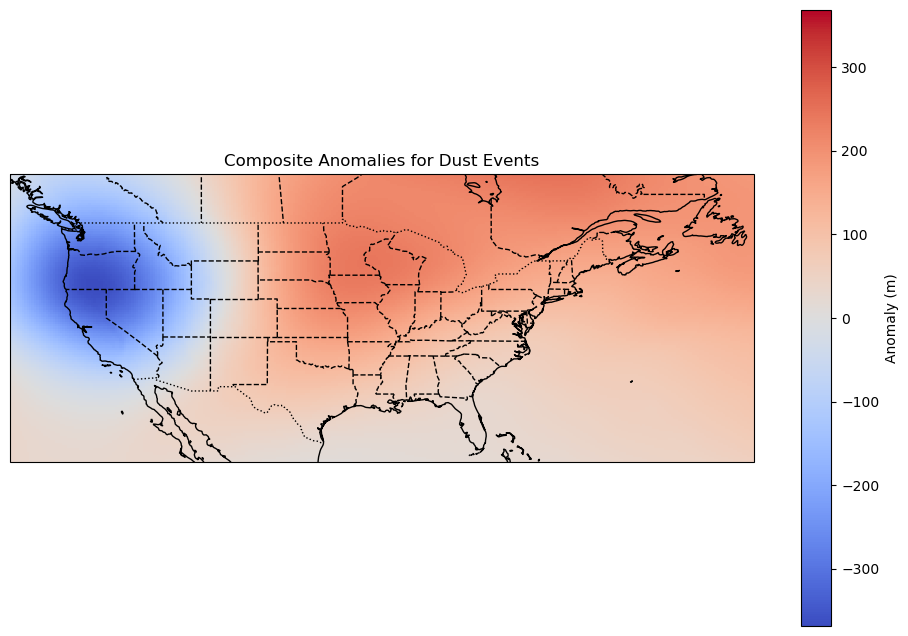

In [2]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

# Load dust event dates
csv_file = 'Book1.csv'

# Read CSV with correct date parsing
dust_events = pd.read_csv(csv_file, parse_dates=['event_date'], dayfirst=True)

# Normalize the 'event_date' column using the .dt accessor
dust_events['event_date'] = pd.to_datetime(dust_events['event_date']).dt.normalize()

# Load the temperature NetCDF data
filename = 'z500_usa.nc'
temp_data = xr.open_dataset(filename)

# Ensure time dimension is in datetime format and normalized
temp_data['time'] = pd.to_datetime(temp_data['time'].values).normalize()

# Verify date alignment
print("Dust event dates:")
print(dust_events['event_date'].unique())

print("\nTemperature data dates:")
print(temp_data['time'].values)

# Filter the data for the dust event dates
composite_temp = temp_data.sel(time=temp_data.time.isin(dust_events['event_date']))

# Check if composite_temp is not empty
if composite_temp.time.size == 0:
    print("No matching dates found in temperature data.")
else:
    # Calculate the climatology (mean over all times)
    climatology = temp_data.mean(dim='time')

    # Calculate anomalies for the dust event dates
    anomalies = composite_temp - climatology

    # Take the mean of the anomalies for plotting
    mean_anomalies = anomalies.mean(dim='time')

    # Plot composite anomalies
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

    # Plot mean anomaly (replace 'z500' with your actual variable name)
    variable_name = 'z500'  # Replace with the correct variable name if different
    mean_anomalies[variable_name].plot(
        ax=ax,
        cmap='coolwarm',
        cbar_kwargs={'label': 'Anomaly (m)'},
        transform=ccrs.PlateCarree()
    )

    # Add geographic features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    states_provinces = NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, linestyle='--')

    # Set title
    plt.title('Composite Anomalies for Dust Events')

    # Show plot
    plt.show()



In [32]:
composite_temp.to_netcdf('anomalies.nc')

/home/precious/anaconda3/lib/python3.11/site-packages/xarray/core/indexing.py:664: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/core/indexing.py:664: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

# Load dust event dates
csv_file = 'Book1.csv'
dust_events = pd.read_csv(csv_file, parse_dates=['event_date'], dayfirst=True)
dust_events['event_date'] = pd.to_datetime(dust_events['event_date']).dt.normalize()

# Load the temperature NetCDF data
filename = 'z500_usa.nc'
temp_data = xr.open_dataset(filename)

# Ensure time dimension is in datetime format and normalized
temp_data['time'] = pd.to_datetime(temp_data['time'].values).normalize()

# Filter the data for the dust event dates
composite_temp = temp_data.sel(time=temp_data.time.isin(dust_events['event_date']))



/home/precious/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [ ]:
# Check if composite_temp is not empty
if composite_temp.time.size == 0:
    print("No matching dates found in temperature data.")
else:
    # Calculate the climatology (mean over all times)
    climatology = temp_data.mean(dim='time')
    
    # Calculate anomalies for the dust event dates
    anomalies = composite_temp - climatology
    
    # Prepare weights based on latitude
    coslat = np.cos(np.deg2rad(anomalies['lat']))
    weights = np.sqrt(coslat)
    weights_2d = weights.broadcast_like(anomalies.isel(time=0))
    
    # Initialize EOF solver
    solver = Eof(anomalies['z500'], weights=weights_2d)
    
    # Number of EOFs to compute
    neofs = 3  # Adjust as needed
    
    # Retrieve EOFs, PCs, and explained variance
    eofs = solver.eofs(neofs=neofs)
    pcs = solver.pcs(npcs=neofs, pcscaling=1)
    variance_fractions = solver.varianceFraction(neigs=neofs)
    
    # Plot EOF patterns
    for i in range(neofs):
        eof = eofs.isel(mode=i)
        
        fig, ax = plt.subplots(
            subplot_kw={'projection': ccrs.PlateCarree()},
            figsize=(12, 6)
        )
        
        eof.plot.contourf(
            ax=ax,
            cmap='RdBu_r',
            levels=21,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={'label': f'EOF {i+1}'}
        )
        
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, linestyle='--')
        ax.set_title(f'EOF {i+1} Pattern (Explained Variance: {variance_fractions.values[i]*100:.2f}%)')
        
        plt.show()
    
    # Plot PCs
    for i in range(neofs):
        pc = pcs.isel(mode=i)
        
        plt.figure(figsize=(12, 4))
        pc.plot()
        plt.title(f'Principal Component {i+1}')
        plt.ylabel('Amplitude')
        plt.xlabel('Time')
        plt.axhline(0, color='k', linewidth=0.5)
        plt.show()


In [10]:
import cartopy.crs as ccrs
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
import pandas as pd

# Load dust event dates
csv_file = 'Book1.csv'
dust_events = pd.read_csv(csv_file, parse_dates=['event_date'], dayfirst=True)

# Load the temperature NetCDF data
filename = 'z500_usa.nc'
temp_data = xr.open_dataset(filename)

# Convert time dimension to datetime
temp_data['time'] = pd.to_datetime(temp_data['time'].values)

# Filter the data for the dust event dates
composite_temp = temp_data.sel(time=temp_data.time.isin(dust_events['event_date']))



/home/precious/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [12]:
# Convert composite temperature data to numpy array
pre_djf = composite_temp.z500.values
lons = composite_temp.lon.values
lats = composite_temp.lat.values



In [16]:
# Compute anomalies by removing the time-mean.
pre_djf_mean = pre_djf.mean(axis=0)
pre_djf = pre_djf - pre_djf_mean

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

# Ensure that pre_djf has the correct shape for EOF analysis
if pre_djf.shape[0] < 2:
    raise ValueError("Not enough time points for EOF analysis. At least 2 time points are required.")

solver = Eof(pre_djf, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading PC time series and the input anomalies at each grid point.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

# Plot the leading EOF (3) expressed as correlation.
for i in range(0, 3):
    plt.figure(figsize=(13, 6.2))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.gridlines()
    fill = ax.contourf(lons, lats, eof1[i, :, :].squeeze(), levels=10, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
    cb = plt.colorbar(fill, orientation='vertical')
    plt.title('EOF ' + str(i + 1), fontsize=16)
    plt.show()

    plt.figure(figsize=(13, 6.2))
    years = np.arange(pre_djf.shape[0])
    plt.plot(years, pc1[:, i], linewidth=2)
    plt.xticks(range(0, pre_djf.shape[0], 10), rotation='vertical')
    plt.axhline(0, color='k')
    plt.xlabel('Time')
    plt.ylabel('PC Amplitude')
    plt.xlim(0, pre_djf.shape[0])
    plt.ylim(np.min(pc1[:, i]), np.max(pc1[:, i]))
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_559980/3956422283.py:2: RuntimeWarning: Mean of empty slice.
  pre_djf_mean = pre_djf.mean(axis=0)


ValueError: Not enough time points for EOF analysis. At least 2 time points are required.

In [2]:
# Load dust event dates
# Replace 'file_path' with the path to the CSV file containing the dust event dates
csv_file = 'Book1.csv'
dust_events = pd.read_csv(csv_file, parse_dates=['event_date'], dayfirst=True)

# Load the NetCDF file into xarray dataset
temp_data = xr.open_dataset(nc_file_temp)

# Convert time dimension to datetime
temp_data['time'] = pd.to_datetime(temp_data['time'].values)



/home/precious/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
# Filter the data for the dust event dates
composite_temp = temp_data.sel(time=temp_data.time.isin(dust_events['event_date']))




In [19]:
# Calculate composite mean
mean_temp = composite_temp.mean(dim='time')

# Plot the composite mean temperature spatially
plt.figure(figsize=(12, 8))
mean_temp.z500.plot.contourf(levels=20, cmap='coolwarm', extend='both')
plt.title('Composite Mean Temperature on Dust Event Days')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

ValueError: conflicting sizes for dimension 'latitude': length 1 on 'z500' and length 121 on {'longitude': 'longitude', 'latitude': 'latitude', 'plev': 'plev'}

In [18]:
composite_temp

<xarray.Dataset> Size: 3kB
Dimensions:    (time: 0, bnds: 2, longitude: 313, latitude: 121, plev: 1)
Coordinates:
  * time       (time) datetime64[ns] 0B 
  * longitude  (longitude) float64 3kB 230.0 230.2 230.5 ... 307.5 307.8 308.0
  * latitude   (latitude) float64 968B 54.0 53.75 53.5 53.25 ... 24.5 24.25 24.0
  * plev       (plev) float64 8B 5e+04
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 0B ...
    z500       (time, plev, latitude, longitude) float32 0B 
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.9rc1 (http...
    Conventions:                CF-1.6
    history:                    Fri Oct 25 19:23:21 2024: cdo selyear,2005/20...
    institution:                European Centre for Medium-Range Weather Fore...
    frequency:                  day
    title:                      "ERA5 reanalysis, https://www.ecmwf.int/en/fo...
    ...                         ...
    geospatial_lat_resolution:  0.25
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1950-01-01
    time_coverage_end:          2024-09-30
    climexp_url:                https://climexp.knmi.nl/select.cgi?era5_z500_...
    CDO:                        Climate Data Operators version 1.9.9rc1 (http...

In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4 as nc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Flatten the data for EOF analysis
if composite_temp.temperature.shape[0] > 1:
    data_flattened = composite_temp.temperature.stack(points=('time', 'lat', 'lon')).values

    # Reshape the flattened data to 2D for PCA
    data_flattened_2d = data_flattened.reshape(-1, data_flattened.shape[-1])

    # Check if the number of samples is greater than or equal to the number of clusters
    n_clusters = 2
    if data_flattened_2d.shape[0] >= n_clusters:
        # Perform PCA (EOF analysis)
        n_components = min(n_clusters, data_flattened_2d.shape[0], data_flattened_2d.shape[1])
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(data_flattened_2d)

        # Perform clustering on the principal components
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(principal_components)

        # Reshape the cluster labels to match the spatial dimensions
        cluster_labels = clusters.reshape((len(lat), len(lon)))

        # Plot the clusters
        fig, axes = plt.subplots(1, n_clusters, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        for i, ax in enumerate(axes):
            ax.set_title(f'Cluster {i + 1}')
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            cluster_data = (cluster_labels == i).astype(int)
            ax.contourf(lon, lat, cluster_data, transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.6)
        plt.suptitle('Cluster Analysis of Dust Event Composite Temperature')
        plt.show()
    else:
        print(f"Not enough samples ({data_flattened_2d.shape[0]}) for {n_clusters} clusters. Clustering analysis skipped.")
else:
    print("Not enough data points for PCA and clustering analysis.")


Not enough samples (1) for 2 clusters. Clustering analysis skipped.


/home/precious/anaconda3/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


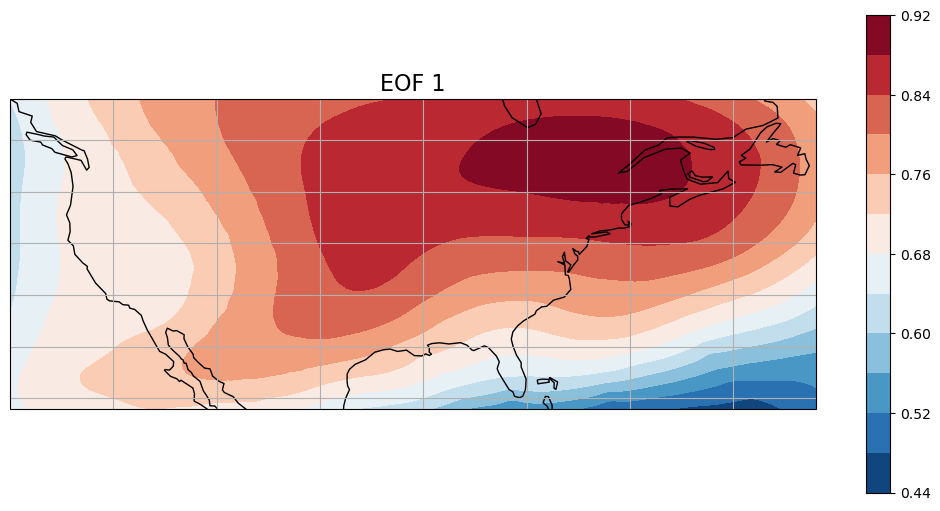

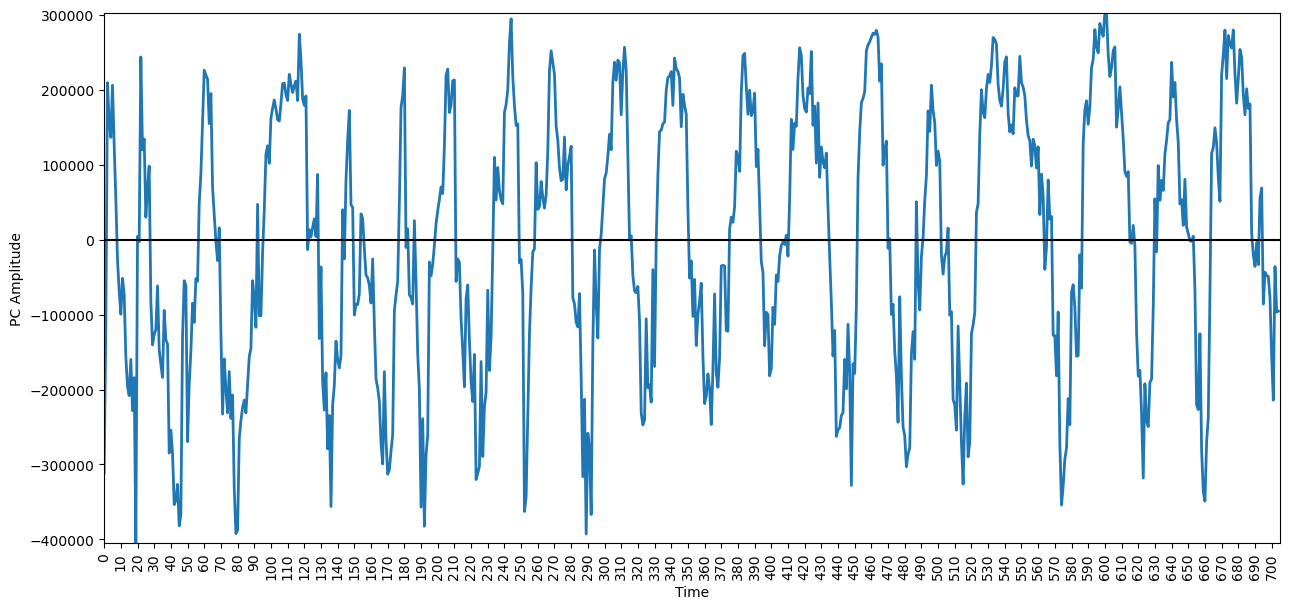

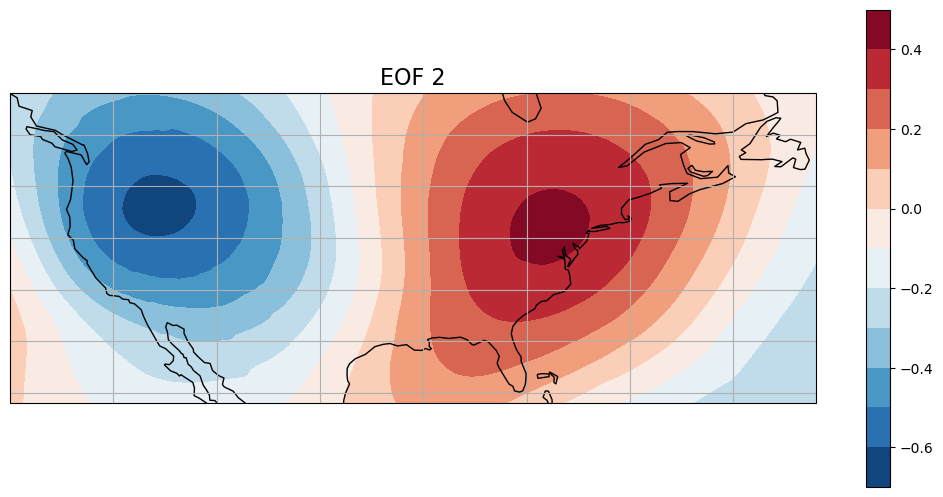

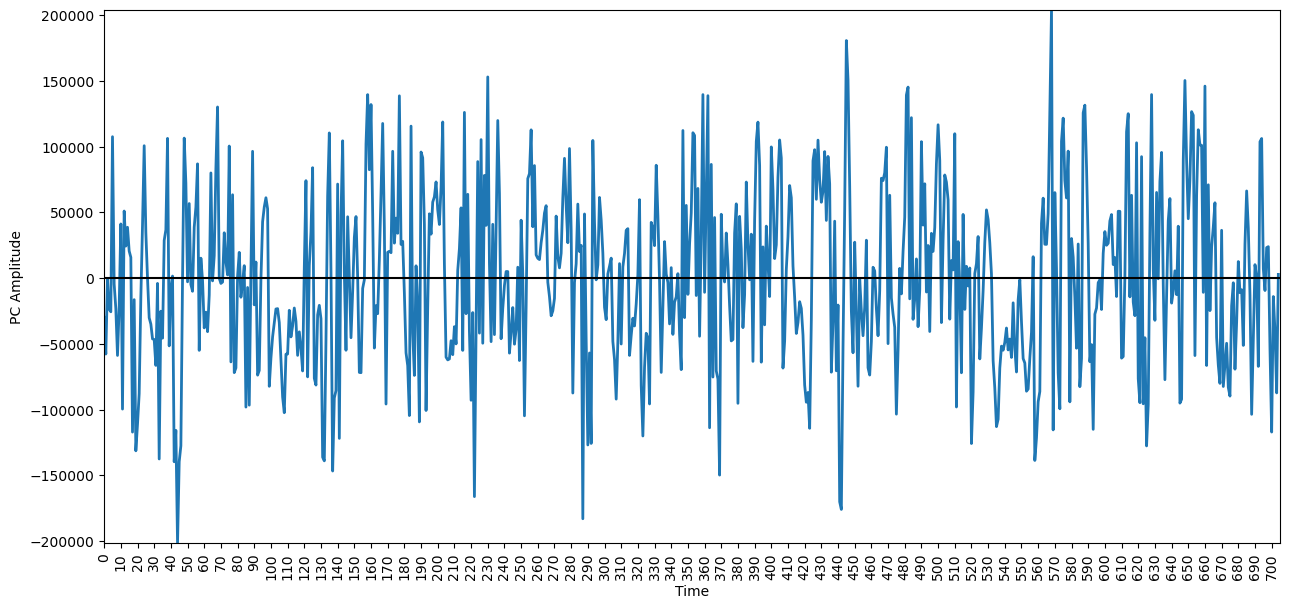

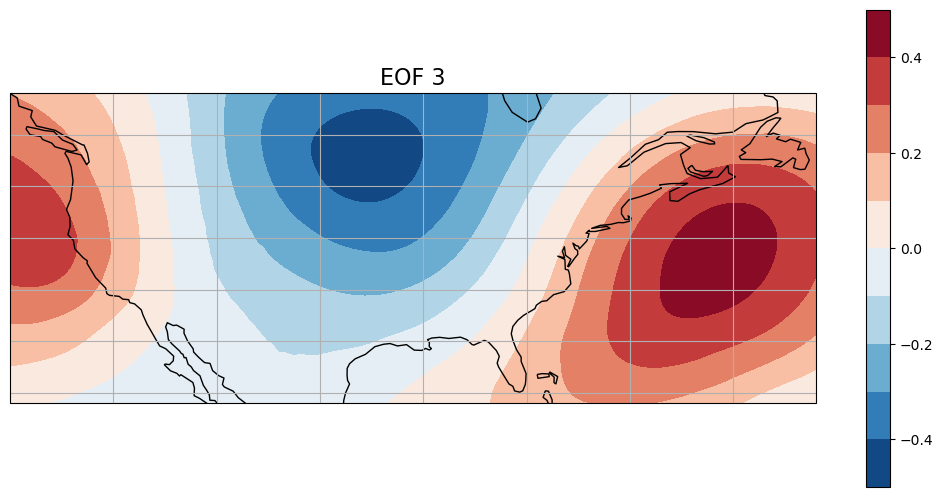

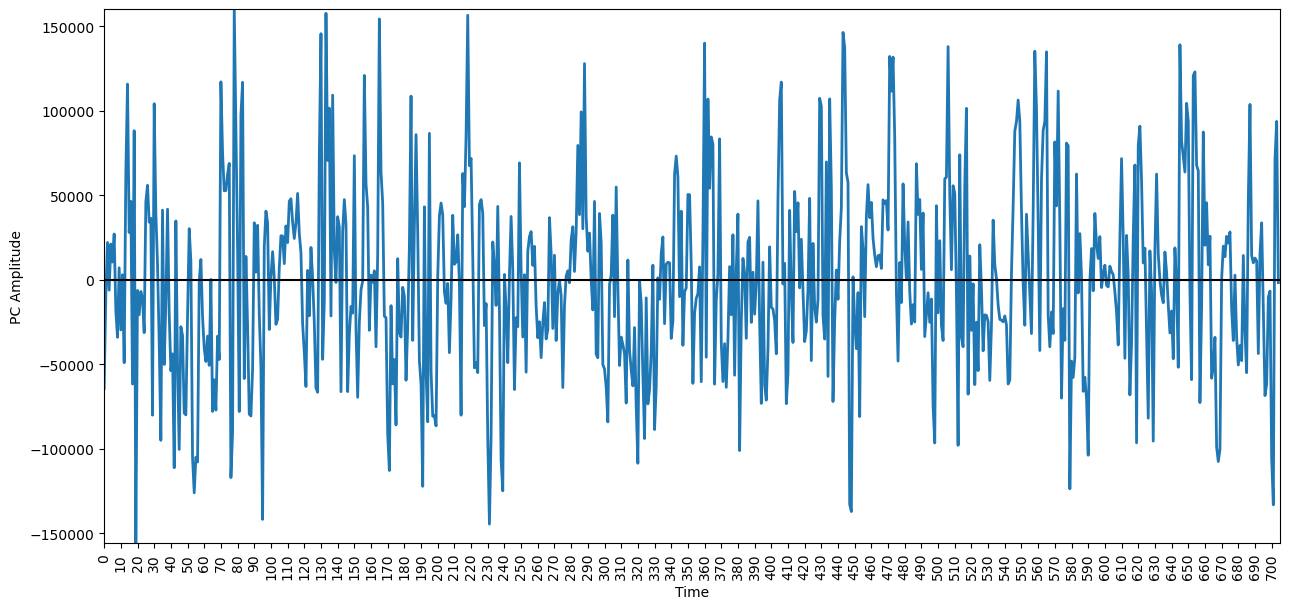

In [4]:
import cartopy.crs as ccrs
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
import pandas as pd


# Convert composite temperature data to numpy array
pre_djf = composite_temp.z500.values
lons = composite_temp.lon.values
lats = composite_temp.lat.values

# Compute anomalies by removing the time-mean.
pre_djf_mean = pre_djf.mean(axis=0)
pre_djf = pre_djf - pre_djf_mean

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(pre_djf, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading PC
#time series and the input anomalies at each grid point.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

# Plot the leading EOF (3) expressed as correlation.
for i in range(0, 3):
    plt.figure(figsize=(13, 6.2))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.gridlines()
    fill = ax.contourf(lons, lats, eof1[i, :, :].squeeze(), levels=10, cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
    cb = plt.colorbar(fill, orientation='vertical')
    plt.title('EOF ' + str(i + 1), fontsize=16)
    plt.show()

    plt.figure(figsize=(13, 6.2))
    years = np.arange(pre_djf.shape[0])
    plt.plot(years, pc1[:, i], linewidth=2)
    plt.xticks(range(0, pre_djf.shape[0], 10), rotation='vertical')
    plt.axhline(0, color='k')
    plt.xlabel('Time')
    plt.ylabel('PC Amplitude')
    plt.xlim(0, pre_djf.shape[0])
    plt.ylim(np.min(pc1[:, i]), np.max(pc1[:, i]))
    plt.tight_layout()
    plt.show()
